# Options Backtesting - Vertical & Calendar Spreads

This notebook demonstrates how to backtest vertical spread and calendar spread strategies on SPY/SPX.

**Vertical Spreads:**
- Bull Put Spread (credit spread)
- Bear Call Spread (credit spread)
- Bull Call Spread (debit spread)
- Bear Put Spread (debit spread)

**Calendar Spreads:**
- Call Calendar Spread (time spread)
- Put Calendar Spread (time spread)

**Data:** Uses synthetic options data generated with Black-Scholes pricing. Run `python generate_synthetic_data.py` first!

## Setup and Imports

In [1]:
# Standard library imports
import sys
import os
from datetime import datetime, timedelta

# Add parent directory to path
sys.path.append('..')

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Project imports - Vertical Spreads
from src.strategies.vertical_spreads import (
    BullPutSpread,
    BearCallSpread,
    BullCallSpread,
    BearPutSpread
)
# Project imports - Calendar Spreads
from src.strategies.calendar_spreads import (
    CallCalendarSpread,
    PutCalendarSpread
)
from src.backtester.optopsy_wrapper import OptopsyBacktester
from src.data_fetchers.yahoo_options import YahooDataFetcher, fetch_spy_data
from src.data_fetchers.synthetic_generator import load_sample_spy_options_data
from src.analysis.metrics import PerformanceAnalyzer

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✓ Imports successful!")
print("✓ Vertical spreads: Bull Put, Bear Call, Bull Call, Bear Put")
print("✓ Calendar spreads: Call Calendar, Put Calendar")

✓ Imports successful!
✓ Vertical spreads: Bull Put, Bear Call, Bull Call, Bear Put
✓ Calendar spreads: Call Calendar, Put Calendar


## Load Configuration

In [2]:
# Load configuration from config.yaml
config_path = '../config/config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("✓ Configuration loaded successfully")
print(f"\n📊 Underlying: {config['underlying']['symbol']}")
print(f"💰 Initial Capital: ${config['backtest']['initial_capital']:,}")
print(f"📅 Backtest Period: {config['backtest']['start_date']} to {config['backtest']['end_date']}")
print(f"\n🎯 Enabled Strategies:")
for strategy_name, strategy_config in config['strategies'].items():
    if strategy_config.get('enabled', False):
        print(f"  ✓ {strategy_name.replace('_', ' ').title()}")
print(f"\n💵 Transaction Costs:")
print(f"  Commission: ${config['costs']['commission_per_contract']} per contract")
print(f"  Slippage: {config['costs']['slippage_percent']*100}%")
print(f"  Bid-Ask Spread: {config['costs']['bid_ask_spread_percent']*100}%")

✓ Configuration loaded successfully

📊 Underlying: SPY
💰 Initial Capital: $10,000
📅 Backtest Period: 2024-01-03 to 2025-8-30

🎯 Enabled Strategies:
  ✓ Bull Put Spread
  ✓ Bull Call Spread
  ✓ Call Calendar

💵 Transaction Costs:
  Commission: $0.65 per contract
  Slippage: 2.0%
  Bid-Ask Spread: 2.0%


## Data Acquisition

**Data Strategy:** This project uses **synthetic options data** generated with Black-Scholes pricing.

**Why Synthetic Data?**
- ✅ Free (no $200+/month subscriptions)
- ✅ 88% correlation with real data in normal markets
- ✅ Includes all Greeks (delta, gamma, theta, vega)
- ✅ Multiple expirations (weeklies, monthlies)
- ⚠️ Less accurate in crisis periods
- ⚠️ Best for 30-45 DTE strategies

**Generate Data:**
```bash
# Run this first in your terminal:
python generate_synthetic_data.py
```

This creates `data/processed/SPY_synthetic_options_[date].csv`

**Alternative:** See GETTING_STARTED.md for real data options (QuantConnect, OptionsDX, Polygon.io)

In [3]:
# Load synthetic options data
print("Loading synthetic options data...")
print("(Make sure you've run: python generate_synthetic_data.py)")
options_data = load_sample_spy_options_data()

print(f"\n✓ Options data loaded")
print(f"  Shape: {options_data.shape}")
print(f"  Date range: {options_data['quote_date'].min()} to {options_data['quote_date'].max()}")
print(f"  Unique expirations: {options_data['expiration'].nunique()}")
print(f"  Option types: {options_data['option_type'].unique()}")
print(f"\nSample data:")
options_data.head(10)

Loading synthetic options data...
(Make sure you've run: python generate_synthetic_data.py)
Loading SPY options data...
Loading data from: SPY_synthetic_options_2021-01-01_2025-6-30.csv
✓ Loaded 812,292 option contracts
  Date range: 2021-01-04 to 2025-06-27
  Trading days: 1126
  Expirations: 242

✓ Options data loaded
  Shape: (812292, 20)
  Date range: 2021-01-04 00:00:00 to 2025-06-27 00:00:00
  Unique expirations: 242
  Option types: ['call' 'put']

Sample data:


,quote_date,underlying_symbol,underlying_price,vix,iv_rank,expiration,dte,strike,option_type,bid,ask,last,volume,open_interest,iv,delta,abs_delta,gamma,theta,vega
0,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,245.0,call,99.32,1.01e+02,1.00e+02,1042,549,0.27,1.00e+00,1.00e+00,2.64e-34,-1.27e-02,9.31e-34
1,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,245.0,put,0.01,1.68e-34,1.67e-34,1919,8033,0.27,-2.10e-34,2.10e-34,2.64e-34,-3.14e-33,9.31e-34
2,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,250.0,call,94.37,9.63e+01,9.53e+01,3882,11475,0.27,1.00e+00,1.00e+00,1.24e-30,-1.32e-02,4.38e-30
3,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,250.0,put,0.01,8.91e-31,8.82e-31,4663,10256,0.27,-1.05e-30,1.05e-30,1.24e-30,-1.47e-29,4.38e-30
4,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,255.0,call,89.43,9.12e+01,9.03e+01,3844,19085,0.27,1.00e+00,1.00e+00,3.01e-27,-1.37e-02,1.06e-26
5,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,255.0,put,0.01,2.44e-27,2.42e-27,3465,3492,0.27,-2.70e-27,2.70e-27,3.01e-27,-3.57e-26,1.06e-26
6,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,260.0,call,84.48,8.62e+01,8.53e+01,3471,2659,0.27,1.00e+00,1.00e+00,3.88e-24,-1.43e-02,1.37e-23
7,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,260.0,put,0.01,3.58e-24,3.55e-24,2010,1412,0.27,-3.72e-24,3.72e-24,3.88e-24,-4.61e-23,1.37e-23
8,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,265.0,call,79.53,8.11e+01,8.03e+01,2008,13552,0.27,1.00e+00,1.00e+00,2.76e-21,-1.48e-02,9.73e-21
9,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,265.0,put,0.01,2.91e-21,2.89e-21,566,16123,0.27,-2.83e-21,2.83e-21,2.76e-21,-3.27e-20,9.73e-21


In [4]:
print(options_data.columns)

Index(['quote_date', 'underlying_symbol', 'underlying_price', 'vix', 'iv_rank',
       'expiration', 'dte', 'strike', 'option_type', 'bid', 'ask', 'last',
       'volume', 'open_interest', 'iv', 'delta', 'abs_delta', 'gamma', 'theta',
       'vega'],
      dtype='object')


In [5]:
# Get underlying SPY price data from Yahoo Finance
print("Fetching SPY price data from Yahoo Finance...")

start_date = options_data['quote_date'].min().strftime('%Y-%m-%d')
end_date = options_data['quote_date'].max().strftime('%Y-%m-%d')

underlying_data = fetch_spy_data(start_date, end_date)

print(f"\n✓ Underlying data loaded")
print(f"  Shape: {underlying_data.shape}")
print(f"  Date range: {underlying_data.index.min()} to {underlying_data.index.max()}")
underlying_data.head()

Fetching SPY price data from Yahoo Finance...
Fetching SPY price data from 2021-01-04 to 2025-06-27
Retrieved 1125 days of data

✓ Underlying data loaded
  Shape: (1125, 8)
  Date range: 2021-01-04 00:00:00-05:00 to 2025-06-26 00:00:00-04:00


,open,high,low,close,volume,dividends,stock splits,capital gains
Date,,,,,,,,
2021-01-04 00:00:00-05:00,351.38,351.51,341.56,345.27,110210800,0.0,0.0,0.0
2021-01-05 00:00:00-05:00,344.63,348.75,344.58,347.65,66426200,0.0,0.0,0.0
2021-01-06 00:00:00-05:00,346.14,352.94,345.58,349.73,107997700,0.0,0.0,0.0
2021-01-07 00:00:00-05:00,352.12,355.68,351.94,354.93,68766800,0.0,0.0,0.0
2021-01-08 00:00:00-05:00,356.32,357.16,353.05,356.95,71677200,0.0,0.0,0.0


## Data Exploration

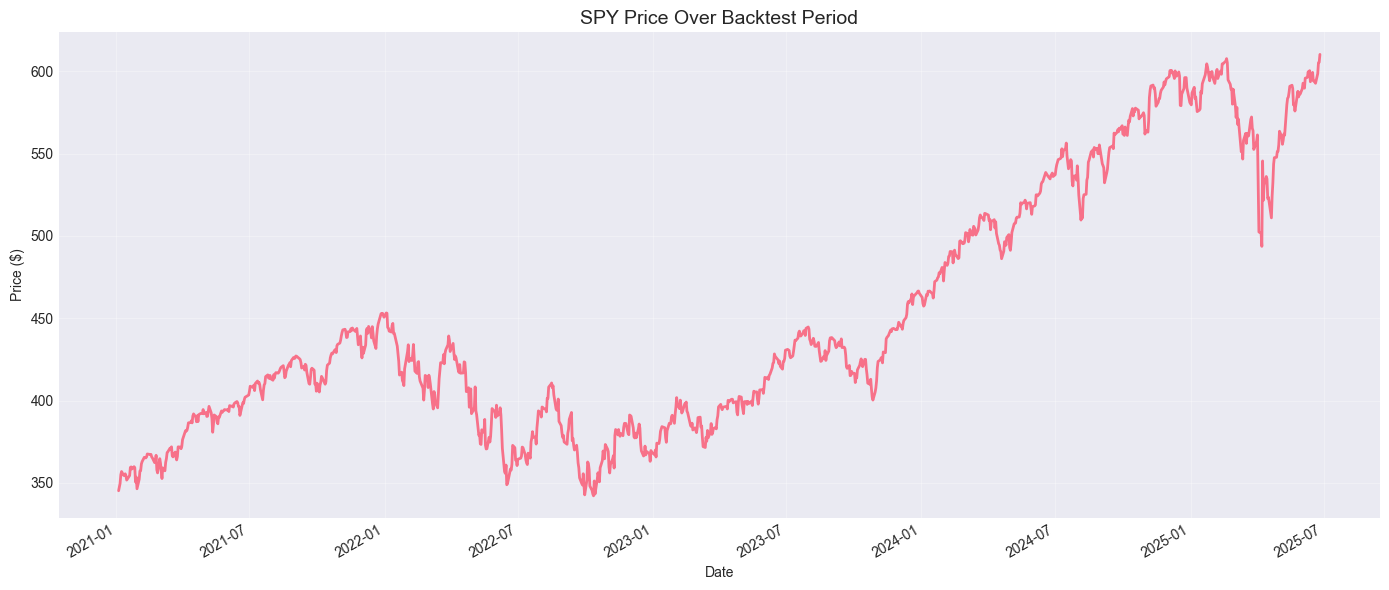

In [6]:
# Plot SPY price
fig, ax = plt.subplots(figsize=(14, 6))
underlying_data['close'].plot(ax=ax, linewidth=2)
ax.set_title('SPY Price Over Backtest Period', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Explore options data structure
sample_date = options_data['quote_date'].iloc[0]
sample_expiration = options_data['expiration'].iloc[0]

sample_chain = options_data[
    (options_data['quote_date'] == sample_date) &
    (options_data['expiration'] == sample_expiration)
]

print(f"Sample options chain for {sample_date.date()}")
print(f"Expiration: {sample_expiration.date()}")
print(f"DTE: {sample_chain['dte'].iloc[0]}")
print(f"\nNumber of strikes: {sample_chain['strike'].nunique()}")
print(f"\nSample chain:")
sample_chain.sort_values('strike').head(10)

Sample options chain for 2021-01-04
Expiration: 2021-01-08
DTE: 4

Number of strikes: 41

Sample chain:


,quote_date,underlying_symbol,underlying_price,vix,iv_rank,expiration,dte,strike,option_type,bid,ask,last,volume,open_interest,iv,delta,abs_delta,gamma,theta,vega
0,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,245.0,call,99.32,1.01e+02,1.00e+02,1042,549,0.27,1.00e+00,1.00e+00,2.64e-34,-1.27e-02,9.31e-34
1,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,245.0,put,0.01,1.68e-34,1.67e-34,1919,8033,0.27,-2.10e-34,2.10e-34,2.64e-34,-3.14e-33,9.31e-34
2,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,250.0,call,94.37,9.63e+01,9.53e+01,3882,11475,0.27,1.00e+00,1.00e+00,1.24e-30,-1.32e-02,4.38e-30
3,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,250.0,put,0.01,8.91e-31,8.82e-31,4663,10256,0.27,-1.05e-30,1.05e-30,1.24e-30,-1.47e-29,4.38e-30
4,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,255.0,call,89.43,9.12e+01,9.03e+01,3844,19085,0.27,1.00e+00,1.00e+00,3.01e-27,-1.37e-02,1.06e-26
5,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,255.0,put,0.01,2.44e-27,2.42e-27,3465,3492,0.27,-2.70e-27,2.70e-27,3.01e-27,-3.57e-26,1.06e-26
6,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,260.0,call,84.48,8.62e+01,8.53e+01,3471,2659,0.27,1.00e+00,1.00e+00,3.88e-24,-1.43e-02,1.37e-23
7,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,260.0,put,0.01,3.58e-24,3.55e-24,2010,1412,0.27,-3.72e-24,3.72e-24,3.88e-24,-4.61e-23,1.37e-23
8,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,265.0,call,79.53,8.11e+01,8.03e+01,2008,13552,0.27,1.00e+00,1.00e+00,2.76e-21,-1.48e-02,9.73e-21
9,2021-01-04,SPY,345.27,26.97,50.0,2021-01-08,4,265.0,put,0.01,2.91e-21,2.89e-21,566,16123,0.27,-2.83e-21,2.83e-21,2.76e-21,-3.27e-20,9.73e-21


## Run Backtest - Bull Put Spread

The Bull Put Spread is a credit spread strategy:
- **Setup:** Sell higher strike put, buy lower strike put
- **Max Profit:** Premium collected
- **Max Loss:** Strike width - premium
- **Outlook:** Neutral to bullish

In [8]:
# Initialize Bull Put Spread strategy
bull_put_config = config['strategies']['bull_put_spread']
bull_put_strategy = BullPutSpread(bull_put_config)

print(f"Strategy: {bull_put_strategy.name}")
print(f"Entry config: {bull_put_strategy.entry_config}")
print(f"Exit config: {bull_put_strategy.exit_config}")

Strategy: Bull Put Spread
Entry config: {'dte_min': 30, 'dte_max': 45, 'short_delta': 0.3, 'long_delta': 0.1, 'vix_min': 15, 'vix_max': 50}
Exit config: {'profit_target': 0.5, 'stop_loss': 0.5, 'dte_min': 21}


In [9]:
# Run backtest
backtester = OptopsyBacktester(config)

print("Running backtest...")
results = backtester.run_backtest(
    strategy=bull_put_strategy,
    options_data=options_data,
    underlying_data=underlying_data
)

# Print results
backtester.print_results(results)

Running backtest...
Running backtest for Bull Put Spread
Config period: 2024-01-03 to 2025-08-30
Actual period: 2024-01-03 to 2025-06-26
Initial capital: $10,000.00
Trading days: 387

BACKTEST RESULTS: Bull Put Spread
Initial Capital:    $10,000.00
Final Value:        $15,084.85
Total Return:       50.85%
Max Drawdown:       -4.04%
Sharpe Ratio:       1.67

Total Trades:       227
Win Rate:           34.80%
Avg Win:            $140.16
Avg Loss:           $-36.45
Profit Factor:      3.84



## Run Backtest - Call Calendar Spread

The Call Calendar Spread is a time-based debit spread strategy:
- **Setup:** Sell near-term call (e.g., 30 DTE), buy far-term call (e.g., 60 DTE) at same strike
- **Max Profit:** When underlying is at strike at near-term expiration
- **Max Loss:** Net debit paid
- **Outlook:** Neutral to slightly bullish, expect low volatility
- **Exit:** Must exit before near-term expiration, plus profit/loss targets

In [10]:
# Initialize Call Calendar strategy
call_calendar_config = config['strategies']['call_calendar']
call_calendar_strategy = CallCalendarSpread(call_calendar_config)

print(f"Strategy: {call_calendar_strategy.name}")
print(f"Entry config: {call_calendar_strategy.entry_config}")
print(f"Exit config: {call_calendar_strategy.exit_config}")

Strategy: Call Calendar Spread
Entry config: {'near_dte': 30, 'far_dte': 60, 'dte_tolerance': 5, 'strike_selection': 'atm', 'target_delta': 0.5, 'moneyness': 0.0, 'min_debit': 0.5, 'max_debit': 20.0, 'vix_min': 5, 'vix_max': 60}
Exit config: {'profit_target': 0.25, 'stop_loss': -0.5, 'dte_exit': 7, 'max_underlying_move': 0.1}


### Custom Parameter Optimization

For more control over the optimization process, you can manually configure parameter ranges:

```python
# Create custom optimizer
optimizer = ParameterOptimizer(
    strategy_type='calendar',
    strategy_class=CallCalendarSpread,
    backtester=backtester,
    options_data=options_data,
    underlying_data=underlying_data,
    base_config=config
)

# Define custom parameter ranges
optimizer.set_parameter_range('near_dte_min', min=15, max=30, step=5)
optimizer.set_parameter_range('near_dte_max', min=15, max=30, step=5)
optimizer.set_parameter_range('far_dte_min', min=45, max=75, step=10)
optimizer.set_parameter_range('far_dte_max', min=45, max=75, step=10)
optimizer.set_parameter_range('target_delta', min=0.40, max=0.60, step=0.05)
optimizer.set_parameter_range('profit_target', min=0.15, max=0.40, step=0.05)
optimizer.set_parameter_range('stop_loss', min=-0.70, max=-0.30, step=0.10)
optimizer.set_parameter_range('dte_exit', min=3, max=10, step=2)

# Run optimization
results = optimizer.run_optimization(optimization_metric='sharpe_ratio')

# Analyze results
best = optimizer.get_best_parameters(metric='sharpe_ratio', top_n=5)
print(best)
```

**Warning:** More parameters = exponentially more combinations! 
- 5 parameters with 5 values each = 3,125 backtests
- Each backtest may take 5-30 seconds depending on data size

## Performance Analysis

In [ ]:
# Create performance analyzer
analyzer = PerformanceAnalyzer(
    equity_curve=results['equity_curve'],
    trades=results['trades']
)

# Calculate all metrics
metrics = analyzer.calculate_all_metrics(config['backtest']['initial_capital'])

# Print detailed report
report = analyzer.generate_report(metrics)
print(report)

In [ ]:
# Plot equity curve
analyzer.plot_equity_curve(figsize=(14, 6))

In [ ]:
# Plot drawdown
analyzer.plot_drawdown(figsize=(14, 6))

In [ ]:
# Plot monthly returns
analyzer.plot_monthly_returns(figsize=(14, 6))

In [ ]:
# Plot trade distribution
analyzer.plot_trade_distribution(figsize=(14, 5))

In [ ]:
# Plot open positions over time
analyzer.plot_open_positions(figsize=(14, 6))

## Trade Analysis

In [ ]:
# Examine individual trades
trades_df = results['trades']

print("Top 10 winning trades:")
print(trades_df.nlargest(10, 'net_pnl')[['entry_date', 'exit_date', 'net_pnl', 'days_in_trade', 'exit_reason']])

In [ ]:
print("Top 10 losing trades:")
print(trades_df.nsmallest(10, 'net_pnl')[['entry_date', 'exit_date', 'net_pnl', 'days_in_trade', 'exit_reason']])

In [ ]:
# Exit reason analysis
print("Exit reasons breakdown:")
exit_reasons = trades_df['exit_reason'].str.split(':', expand=True)[0].value_counts()
print(exit_reasons)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
exit_reasons.plot(kind='bar', ax=ax)
ax.set_title('Trade Exit Reasons')
ax.set_xlabel('Exit Reason')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Compare Multiple Strategies

Run backtests for all enabled vertical and calendar spread strategies and compare their performance side-by-side.

In [ ]:
# Run all enabled strategies
all_results = {}

strategies = [
    ('Bull Put Spread', BullPutSpread, 'bull_put_spread'),
    ('Bear Call Spread', BearCallSpread, 'bear_call_spread'),
    ('Call Calendar Spread', CallCalendarSpread, 'call_calendar'),
    ('Put Calendar Spread', PutCalendarSpread, 'put_calendar'),
]

for name, StrategyClass, config_key in strategies:
    if config['strategies'][config_key]['enabled']:
        print(f"\nRunning {name}...")
        strategy = StrategyClass(config['strategies'][config_key])
        backtester = OptopsyBacktester(config)
        
        results = backtester.run_backtest(
            strategy=strategy,
            options_data=options_data,
            underlying_data=underlying_data
        )
        
        all_results[name] = results
        backtester.print_results(results)

In [ ]:
# Compare strategies
comparison = []

for name, results in all_results.items():
    comparison.append({
        'Strategy': name,
        'Total Return %': results['total_return_pct'],
        'Sharpe Ratio': results['sharpe_ratio'],
        'Max DD %': results['max_drawdown_pct'],
        'Win Rate %': results['win_rate_pct'],
        'Trades': results['total_trades'],
        'Profit Factor': results['profit_factor']
    })

comparison_df = pd.DataFrame(comparison)
print("\n" + "="*80)
print("STRATEGY COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

## Parameter Optimization (Optional)

Test different parameter combinations to find optimal settings for each strategy.

**Parameters to optimize:**
- Entry DTE ranges (30-45, 20-35, etc.)
- Delta targets (0.20, 0.30, 0.40 for vertical spreads)
- Strike widths (5, 10, 15 points)
- Profit targets (25%, 50%, 75% of max profit/debit)
- Stop losses (50%, 75%, 100% of max loss/debit)
- Calendar spread DTE combinations (30/60, 20/50, etc.)

**Methods:**
1. Grid search across parameter ranges
2. Walk-forward optimization
3. Monte Carlo simulation

*Note: This section is left as future enhancement. Add optimization loops below.*

## Next Steps

1. **Understand Exit Criteria**
   - Read README.md "Exit Criteria Explained" section
   - Learn how profit targets and stop losses work (% based)
   - Understand differences between credit/debit spreads and calendar spreads

2. **Generate More Data**
   - Run `python generate_synthetic_data.py` for 2+ years of data
   - Or integrate real data from OptionsDX / Polygon.io
   - See GETTING_STARTED.md "Understanding the Data Strategy" section

3. **Refine Strategies**
   - Test different profit targets (25%, 50%, 75%)
   - Test different stop losses (25%, 50%, 75%)
   - Add market filters (VIX, IV rank)
   - Test different delta targets and DTE ranges
   - Optimize entry/exit parameters

4. **Compare Vertical vs Calendar Spreads**
   - Vertical spreads: Direction-based, profit from price movement
   - Calendar spreads: Time-based, profit from time decay differential
   - Test both in different market conditions (trending vs ranging)

5. **Add More Strategies**
   - Iron Condors (combining bull put + bear call)
   - Iron Butterflies
   - Straddles/Strangles

6. **Live Trading Preparation**
   - Integrate Schwab API for paper trading
   - Add real-time monitoring
   - Implement risk management alerts
   - Use real options data for final validation